In [141]:
%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [198]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
import os
import pathlib
from tqdm import tqdm_notebook as tqdm
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import RunningAverage
from ignite.contrib.handlers.tqdm_logger import ProgressBar
from ignite.handlers import ModelCheckpoint
from sklearn.model_selection import train_test_split 
from ignite.metrics import Loss
from functools import partial

In [3]:
torch.__version__, np.__version__

('1.3.1', '1.16.3')

For training versions: ('1.3.1', '1.16.3') was used

In [173]:
config = {
    "device": "cuda",
    "test_size": 0.1,
    "random_seed": 42,
    "resize": (512, 384),
    "batch_size": 4,
    "learning_rate": 0.0001
}

In [154]:
class SegmentationDataset(Dataset):
    def __init__(self, data_path, dataset_mean=(69.2614, 55.9220, 32.6043), out_size=(512, 384)):
        all_filenames = [x.name for x in pathlib.Path(data_path).resolve().iterdir()]
        inputs = [path for path in all_filenames if "gt" not in path.lower()]
        self.all_pairs = []
        self.out_size = out_size
        self.mean = torch.tensor(dataset_mean)
        for input_path in inputs:
            labels = [
                path
                for path in all_filenames
                if "gt" in path.lower() and path.startswith(str(pathlib.Path(input_path).with_suffix("")))
            ]
            if labels:
                self.all_pairs.append((data_path + "/" + input_path, data_path + "/" + labels[0]))
        self.all_data = []
        self.all_images = []
        for input_path, label_path in tqdm(self.all_pairs, desc="Loading images to RAM"):
            input_image = Image.open(input_path).resize(self.out_size, Image.LANCZOS)
            label_image = Image.open(label_path).resize(self.out_size, Image.NEAREST)
            input_array = np.array(input_image, dtype=np.float32)
            label_array = np.array(label_image)[:, :, 0]
            label_array[(label_array <= 128) & (label_array > 0)] = 1
            label_array[label_array > 128] = 2
            input_normalized = ((torch.from_numpy(input_array) - self.mean) / 255.0).permute(2, 0, 1)
            self.all_data.append((input_normalized, torch.LongTensor(label_array)))
            self.all_images.append((input_image, label_image))

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        return self.all_data[idx]
    
    def get_image(self, idx):
        return self.all_images[idx]

In [155]:
dataset = SegmentationDataset("./data/training-resized", out_size=config["resize"])

In [158]:
train_idx, test_idx = train_test_split(
    np.arange(len(dataset)),
    test_size=config["test_size"],
    random_state=config["random_seed"],
    shuffle=True,
)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

In [159]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.double_conv(x)

In [160]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [161]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, dropout, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = nn.Sequential(
            DoubleConv(in_channels, out_channels), 
            nn.Dropout2d(p=dropout)
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [162]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [163]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128, 0.2)
        self.down2 = Down(128, 256, 0.2)
        self.down3 = Down(256, 512, 0.2)
        self.down4 = Down(512, 512, 0.5)
        self.up1 = Up(1024, 256, 0.2, bilinear)
        self.up2 = Up(512, 128, 0.2, bilinear)
        self.up3 = Up(256, 64, 0.2, bilinear)
        self.up4 = Up(128, 64, 0.0, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [164]:
def dice_loss(logits, true, eps=1e-7):
    """Computes the Sørensen–Dice loss.
    Note that PyTorch optimizers minimize a loss. In this
    case, we would like to maximize the dice loss so we
    return the negated dice loss.
    Args:
        true: a tensor of shape [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        eps: added to the denominator for numerical stability.
    Returns:
        dice_loss: the Sørensen–Dice loss.
    """
    num_classes = logits.shape[1]
    print(logits.shape)
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

In [165]:
class SoftDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        print(logits.shape)
        probs = F.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)

        score = 2. * (intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - score.sum() / num
        return score

### Training

In [202]:
model = UNet(3,3)

In [ ]:
def improvement_function(testing_evaluator, test_data_loader, trainer):
    testing_evaluator.run(test_data_loader)
    metrics = testing_evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg loss: {:.3f}".format(trainer.state.epoch, metrics["cel"]))

    return -metrics["cel"]


train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

optimizer = torch.optim.AdamW(model.parameters(), lr=config["learning_rate"])
loss = nn.CrossEntropyLoss()

trainer = create_supervised_trainer(model, optimizer, loss, device=config["device"])
evaluator = create_supervised_evaluator(model, metrics={"cel": Loss(loss)}, device=config["device"])

checkpoint = ModelCheckpoint(
    "./models",
    f"unet",
    score_name="cel",
    score_function=partial(improvement_function, evaluator, test_data_loader),
    n_saved=2,
    create_dir=True,
    require_empty=False,
)

trainer.add_event_handler(
    Events.EPOCH_COMPLETED, checkpoint, {f"W{config['resize'][0]}_H{config['resize'][1]}": model}
)

RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

pbar = ProgressBar(persist=True)
pbar.attach(trainer, ["loss"])

state = trainer.run(train_data_loader, max_epochs=5)

In [134]:
result = model.forward(dataset[0][0].unsqueeze(0).to(device))

In [135]:
probab = nn.Softmax().forward(result[0])

In [136]:
result_cuda = probab.argmax(dim=0)

In [137]:
numpy_result = result_cuda.cpu().numpy()

In [138]:
numpy_result[numpy_result == 1] = 128

In [139]:
numpy_result[numpy_result == 2] = 255

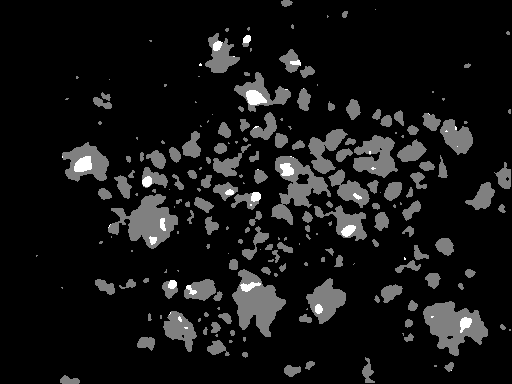

In [126]:
Image.fromarray(numpy_result.astype("uint8"), mode="L")

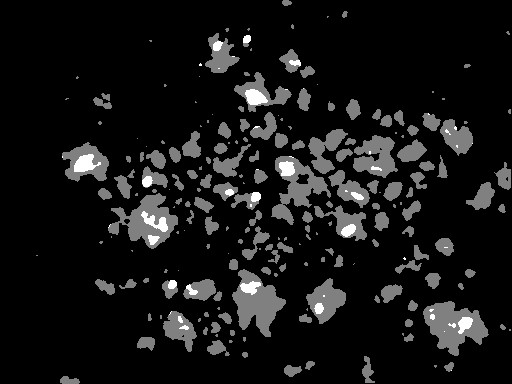

In [133]:
Image.fromarray(numpy_result.astype("uint8"), mode="L")

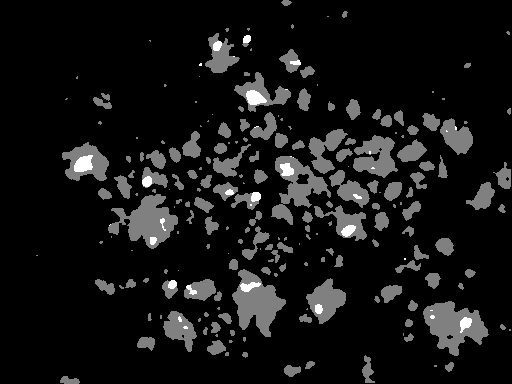

In [140]:
Image.fromarray(numpy_result.astype("uint8"), mode="L")

In [114]:
np.array(y).dtype

dtype('uint8')

In [109]:
(np.array(y)[:, :, 0] == 0).sum()

164234

In [110]:
(np.array(y)[:, :, 0] == 128).sum()

31673

In [111]:
(np.array(y)[:, :, 0] == 255).sum()

701

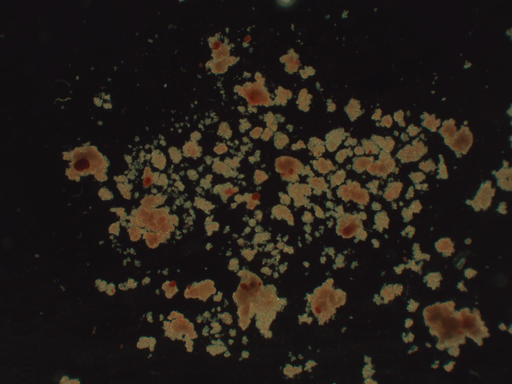

In [84]:
dataset.get_image(0)[0]